# Matching q=Normal(loc, softplus(uscale)) to p=Normal(0,1) by minimizing KL(q|p)

In [116]:
%load_ext autoreload
%autoreload 2
%pip install -q torch

Note: you may need to restart the kernel to use updated packages.


In [117]:
import torch
import numpy as np

In [118]:
if torch.cuda.is_available():
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
    ENV = torch.cuda
    print("Using GPU")
else:
    torch.set_default_tensor_type('torch.FloatTensor')
    ENV = torch
    print("Using CPU")

Using CPU


In [119]:
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = (5, 5) # Width and height

import seaborn as sns; 
sns.set(); 
sns.set(font_scale=2); 
sns.set_style("white"); 

In [120]:
import sys
sys.path.append("../")

In [121]:
import reparameterized as r
from reparameterized import sampling
from reparameterized import densities

## Create q

In [122]:
parameter_shape = (3,)
parameter_init_value = torch.randn(torch.Size(parameter_shape))

sampler, variational_params, aux_objs = sampling.create_factorized_gaussian_sampler(parameter_init_value,
    loc_initalization=lambda parameter_init_value: parameter_init_value.clone().detach()+20,
    uscale_initialization=lambda parameter_init_value: torch.randn_like(parameter_init_value)*20,
)

In [123]:
variational_params

{'loc': tensor([18.6674, 18.8212, 21.1151], requires_grad=True),
 'unnormalized_scale': tensor([  0.7450,   1.3804, -22.8532], requires_grad=True)}

In [124]:
samples, nlls = sampler(n_samples=10240)
samples.shape, nlls.shape

(torch.Size([10240, 3]), torch.Size([10240]))

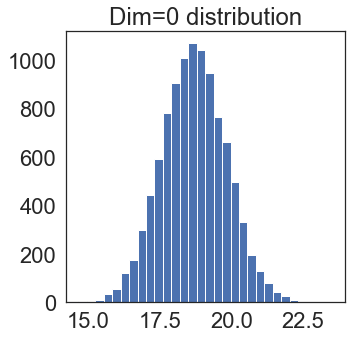

In [125]:
plt.hist(samples[:,0].cpu().detach().numpy(), bins=30);
plt.title("Dim=0 distribution");

## Create p

In [126]:
calc_p_nll = densities.create_gaussian_nll(parameter_shape)

In [127]:
p_nlls = calc_p_nll(samples)
p_nlls.shape

torch.Size([10240])

## Optimize

In [128]:
optimized_parameters = variational_params.values()
optimizer = torch.optim.Adam(optimized_parameters, lr=0.1) 
n_epochs = 10000
n_posterior_samples = 100

for e in range(n_epochs):
    optimizer.zero_grad()

    samples, q_nlls = sampler(n_samples=n_posterior_samples)
    p_nlls = calc_p_nll(samples)
    KLD = p_nlls-q_nlls

    loss_vi = KLD.mean()
    loss_vi.backward()
    optimizer.step()

    if e<10 or e%100==0:
        print(f"epoch={e}: loss={loss_vi: .4f}")

epoch=0: loss= 591.3127
epoch=1: loss= 581.8459
epoch=2: loss= 582.8884
epoch=3: loss= 577.7267
epoch=4: loss= 569.5424
epoch=5: loss= 563.8992
epoch=6: loss= 558.2569
epoch=7: loss= 554.4103
epoch=8: loss= 544.3384
epoch=9: loss= 548.1510
epoch=100: loss= 177.9917
epoch=200: loss= 34.2460
epoch=300: loss= 4.5056
epoch=400: loss= 0.4106
epoch=500: loss= 0.0527
epoch=600: loss= 0.0097
epoch=700: loss=-0.0003
epoch=800: loss=-0.0129
epoch=900: loss= 0.0169
epoch=1000: loss= 0.0097
epoch=1100: loss= 0.0074
epoch=1200: loss=-0.0042
epoch=1300: loss= 0.0014
epoch=1400: loss= 0.0052
epoch=1500: loss= 0.0152
epoch=1600: loss=-0.0080
epoch=1700: loss= 0.0076
epoch=1800: loss=-0.0056
epoch=1900: loss= 0.0077
epoch=2000: loss=-0.0014
epoch=2100: loss=-0.0047
epoch=2200: loss=-0.0041
epoch=2300: loss= 0.0223
epoch=2400: loss= 0.0060
epoch=2500: loss= 0.0097
epoch=2600: loss= 0.0025
epoch=2700: loss= 0.0108
epoch=2800: loss= 0.0070
epoch=2900: loss= 0.0125
epoch=3000: loss=-0.0089
epoch=3100: loss

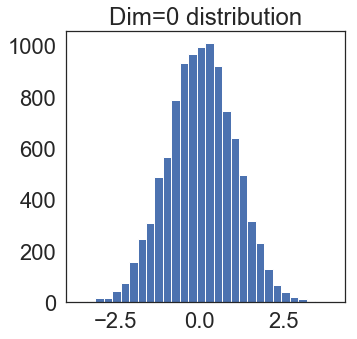

In [129]:
samples, nlls = sampler(n_samples=10240)
plt.hist(samples[:,0].cpu().detach().numpy(), bins=30);
plt.title("Dim=0 distribution");